In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torchvision
from torchvision import datasets, transforms, models
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict
from PIL import Image
import seaborn as sns
import splitfolders
from IPython.display import display, HTML

import torchtext
from torchtext.data import get_tokenizer   # for tokenization
from collections import Counter     # for tokenizer


In [5]:
# splitfolders.ratio("Food Images", output="food_images", 
#                    seed=30, ratio=(.7, .2, .1), 
#                    group_prefix=None)

In [3]:
data_df = pd.read_csv('Food Ingredients and Recipe Dataset with Image Name Mapping.csv')
data_df.iloc[1,4]

'crispy-salt-and-pepper-potatoes-dan-kluger'

In [7]:
data_dir = './food_images'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
test_dir = data_dir + '/test'

In [8]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485,0.456,0.406],
                                                           [0.229,0.224,0.225])])
valid_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(size=224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485,0.456,0.406],
                                                        [0.229,0.224,0.225])])
test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(size=224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485,0.456,0.406],
                                                        [0.229,0.224,0.225])])

# train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
# valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
# test_data = datasets.ImageFolder(test_dir, transform=test_transforms)


# trainloader = torch.utils.data.DataLoader(train_data,batch_size = 64, shuffle=True)
# validloader = torch.utils.data.DataLoader(valid_data,batch_size = 64, shuffle=True)
# testloader = torch.utils.data.DataLoader(test_data,batch_size = 64, shuffle=True)

In [9]:
class Vocab:
    def __init__(self, min_freq = 1):
        self.itos = {0:'<PAD>',1:'<START>',2:'<END>',3:'<UNK>'}
        self.stoi = {'<PAD>':0,'<START>':1,'<END>':2,'<UNK>':3}

        self.min_freq = min_freq

        self.tokenizer = get_tokenizer('basic_english')
        self.frequencies = Counter()

    def __len__(self):
        return len(self.itos)
    
    def build_vocab(self, sentence_list):
        idx = 4
        for sentence in sentence_list:
            sentence_tokens = self.tokenizer(str(sentence))
            self.frequencies.update(sentence_tokens)
            #TODO: handle null sentences/instructions
            for token in sentence_tokens:
                if token not in self.stoi.keys() and self.frequencies[token] >= self.min_freq:
                    self.stoi[token] = idx
                    self.itos[idx] = token
                    idx +=1

    def numericalize(self, sentence):
        sentence_tokens = self.tokenizer(str(sentence))
        return [self.stoi[token] if token in self.stoi else self.stoi['<UNK>'] for token in sentence_tokens]



In [10]:
class CollateFn:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        recipes = [item[1] for item in batch]
        recipes = pad_sequence(recipes, batch_first=False, padding_value=self.pad_idx)

        return imgs, recipes

In [11]:
class CustomDataset(Dataset):
    def __init__(self, img_dir, recipe_csv, transform = None, min_freq = 3):
        self.img_dir = img_dir
        self.transform = transform
        init_df = pd.read_csv(recipe_csv)
        ###TODO cleaning function :
        # clean_df = init_df.dropna(subset=['Instructions'], inplace=True)
        clean_df = init_df[init_df["Image_Name"] != '#NAME?']
        
        self.recipe_df = clean_df
        self.tokenizer = get_tokenizer('basic_english')

        self.vocab = Vocab(min_freq)
        self.vocab.build_vocab(self.recipe_df["Instructions"].tolist())


    def __len__(self):
        return len(self.recipe_df)
    
    def __getitem__(self, index):
        img_file = os.path.join(self.img_dir, self.recipe_df.iloc[index,4] + '.jpg')
        img = Image.open(img_file)
        img = img.convert('RGB')
        img_name = self.recipe_df.iloc[index,1]
        recipe = self.recipe_df.iloc[index,3]

        recipe_tokens = []
        recipe_tokens += [self.vocab.stoi['<START>']]
        recipe_tokens += self.vocab.numericalize(str(recipe))
        recipe_tokens += [self.vocab.stoi['<END>']] 


        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(recipe_tokens)


In [12]:
torch_data = CustomDataset(recipe_csv='Food Ingredients and Recipe Dataset with Image Name Mapping.csv',
                                    img_dir='Food Images', transform=train_transforms)

tensor([[[ 1.9920,  1.9920,  1.9749,  ...,  0.3652,  0.3652,  0.3652],
         [ 1.9920,  1.9920,  1.9749,  ...,  0.1597,  0.1426,  0.1426],
         [ 1.9749,  1.9749,  1.9920,  ..., -0.2342, -0.2856, -0.3198],
         ...,
         [-0.6623, -0.7308, -0.8849,  ...,  1.2385,  1.4612,  1.5468],
         [-0.3369, -0.4397, -0.6965,  ...,  1.1187,  1.3242,  1.3927],
         [-0.1828, -0.3027, -0.5938,  ...,  1.0502,  1.2557,  1.3242]],

        [[ 2.1310,  2.1310,  2.1310,  ..., -0.9678, -0.9678, -0.9678],
         [ 2.1310,  2.1310,  2.1485,  ..., -1.0903, -1.0903, -1.1078],
         [ 2.1485,  2.1485,  2.1660,  ..., -1.3179, -1.3529, -1.3704],
         ...,
         [-0.8803, -0.9503, -1.1253,  ..., -1.7206, -1.4230, -1.3004],
         [-0.5301, -0.6352, -0.8978,  ..., -1.8081, -1.5805, -1.4930],
         [-0.3550, -0.4776, -0.7752,  ..., -1.8606, -1.6681, -1.5805]],

        [[ 2.3960,  2.3960,  2.4134,  ..., -1.5604, -1.5604, -1.5604],
         [ 2.3960,  2.3960,  2.4134,  ..., -1

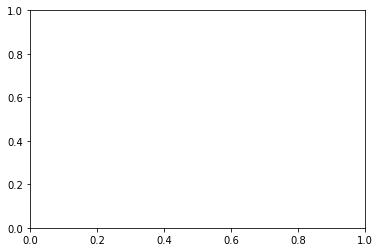

In [13]:
img,recipe_tokens = torch_data[10]

fig, ax = plt.subplots()
img


In [14]:
[torch_data.vocab.itos[token] for token in recipe_tokens.tolist()]

['<START>',
 'put',
 'the',
 'chipotle',
 'peppers',
 'and',
 'adobo',
 'sauce',
 'in',
 'a',
 'small',
 'food',
 'processor',
 'or',
 'blender',
 'and',
 'blend',
 'until',
 'the',
 'mixture',
 'turns',
 'into',
 'a',
 'smooth',
 'purée',
 '.',
 'set',
 'aside',
 '.',
 'the',
 'chipotle',
 'purée',
 'can',
 'be',
 'made',
 'in',
 'advance',
 ',',
 'stored',
 'in',
 'an',
 'airtight',
 'container',
 ',',
 'and',
 'refrigerated',
 'for',
 'up',
 'to',
 '2',
 'months',
 '.',
 'on',
 'a',
 'cutting',
 'board',
 ',',
 'sprinkle',
 'the',
 'garlic',
 'with',
 'a',
 'large',
 'pinch',
 'of',
 'salt',
 'and',
 'gather',
 'it',
 'into',
 'a',
 'small',
 'mound',
 '.',
 'holding',
 'the',
 'blunt',
 'side',
 'of',
 'the',
 'knife',
 'with',
 'both',
 'hands',
 ',',
 'press',
 'and',
 'scrape',
 'the',
 '<UNK>',
 'sharp',
 'end',
 ',',
 'holding',
 'it',
 'at',
 'a',
 'slight',
 'angle',
 ',',
 'across',
 'the',
 'garlic',
 'mound',
 'to',
 'flatten',
 'it',
 '.',
 'repeat',
 ',',
 'dragging',
 

In [15]:
image_data_ref = pd.read_csv('Food Ingredients and Recipe Dataset with Image Name Mapping.csv')
image_data_ref.ndim
display(image_data_ref)


,Unnamed: 0,Title,Ingredients,Instructions,Image_Name,Cleaned_Ingredients
0,0,Miso-Butter Roast Chicken With Acorn Squash Pa...,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher...","Pat chicken dry with paper towels, season all ...",miso-butter-roast-chicken-acorn-squash-panzanella,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher..."
1,1,Crispy Salt and Pepper Potatoes,"['2 large egg whites', '1 pound new potatoes (...",Preheat oven to 400°F and line a rimmed baking...,crispy-salt-and-pepper-potatoes-dan-kluger,"['2 large egg whites', '1 pound new potatoes (..."
2,2,Thanksgiving Mac and Cheese,"['1 cup evaporated milk', '1 cup whole milk', ...",Place a rack in middle of oven; preheat to 400...,thanksgiving-mac-and-cheese-erick-williams,"['1 cup evaporated milk', '1 cup whole milk', ..."
3,3,Italian Sausage and Bread Stuffing,"['1 (¾- to 1-pound) round Italian loaf, cut in...",Preheat oven to 350°F with rack in middle. Gen...,italian-sausage-and-bread-stuffing-240559,"['1 (¾- to 1-pound) round Italian loaf, cut in..."
4,4,Newton's Law,"['1 teaspoon dark brown sugar', '1 teaspoon ho...",Stir together brown sugar and hot water in a c...,newtons-law-apple-bourbon-cocktail,"['1 teaspoon dark brown sugar', '1 teaspoon ho..."
...,...,...,...,...,...,...
13496,13496,Brownie Pudding Cake,"['1 cup all-purpose flour', '2/3 cup unsweeten...",Preheat the oven to 350°F. Into a bowl sift to...,brownie-pudding-cake-14408,"['1 cup all-purpose flour', '2/3 cup unsweeten..."
13497,13497,Israeli Couscous with Roasted Butternut Squash...,"['1 preserved lemon', '1 1/2 pound butternut s...",Preheat oven to 475°F.\nHalve lemons and scoop...,israeli-couscous-with-roasted-butternut-squash...,"['1 preserved lemon', '1 1/2 pound butternut s..."
13498,13498,Rice with Soy-Glazed Bonito Flakes and Sesame ...,['Leftover katsuo bushi (dried bonito flakes) ...,"If using katsuo bushi flakes from package, moi...",rice-with-soy-glazed-bonito-flakes-and-sesame-...,['Leftover katsuo bushi (dried bonito flakes) ...
13499,13499,Spanakopita,['1 stick (1/2 cup) plus 1 tablespoon unsalted...,Melt 1 tablespoon butter in a 12-inch heavy sk...,spanakopita-107344,['1 stick (1/2 cup) plus 1 tablespoon unsalted...


In [16]:
##recipe

In [17]:
tokenizer = get_tokenizer('basic_english')

In [18]:
resnet = models.resnet101(pretrained = True)
resnet.fc.in_features

C:\Users\erice\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\erice\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


2048

In [19]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        self.arch = models.resnet101(pretrained = True)
        self.arch.fc = nn.Linear(self.arch.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.times = []
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        features = self.arch(images)
        return self.dropout(self.relu(features))
    
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, recipe_tokens):
        embeddings = self.dropout(self.embed(recipe_tokens))
        #Add features as a dimension for embeddings as the 'first' input in the sequence
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

In [169]:
class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, recipe_tokens):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, recipe_tokens)
        return outputs

    def recipe_generate(self, image, vocabulary, max_length=50):
        result_recipe = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                
                output_dist = output.data.view(-1).div(0.8).exp()
                top_i = torch.multinomial(output_dist, 1)[0]
                
                result_recipe.append(top_i.item())

                x = self.decoderRNN.embed(torch.unsqueeze(top_i, 0)).unsqueeze(0)

                if vocabulary.itos[top_i.item()] == "<END>":
                    break

        return [vocabulary.itos[idx] for idx in result_recipe]

In [90]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("Saving checkpoint ...")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("Loading checkpoint ... ")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    step = checkpoint["step"]
    return step

def train():
    # train_transforms = transforms.Compose([transforms.RandomRotation(30),
    #                                    transforms.RandomResizedCrop(224),
    #                                    transforms.RandomHorizontalFlip(),
    #                                    transforms.ToTensor(),
    #                                    transforms.Normalize([0.485,0.456,0.406],
    #                                                        [0.229,0.224,0.225])])
    # valid_transforms = transforms.Compose([transforms.Resize(255),
    #                                     transforms.CenterCrop(size=224),
    #                                     transforms.ToTensor(),
    #                                     transforms.Normalize([0.485,0.456,0.406],
    #                                                         [0.229,0.224,0.225])])
    # test_transforms = transforms.Compose([transforms.Resize(255),
    #                                     transforms.CenterCrop(size=224),
    #                                     transforms.ToTensor(),
    #                                     transforms.Normalize([0.485,0.456,0.406],
    #                                                         [0.229,0.224,0.225])])

    train_dls = torch.utils.data.DataLoader(torch_data, 
                                           batch_size=64, shuffle=False,
                                           collate_fn = CollateFn(pad_idx=torch_data.vocab.stoi["<PAD>"]))
    torch.backends.cudnn.benchmark = True
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    load_model = False
    save_model = True
    train_CNN = False

    # Hyperparameters
    embed_size = 256
    hidden_size = 256
    vocab_size = len(torch_data.vocab)
    num_layers = 2
    learning_rate = 3e-4
    num_epochs = 10

   
    step = 0

    # initialize model, loss etc
    model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=torch_data.vocab.stoi["<PAD>"])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Only finetune the CNN
    for param in model.encoderCNN.parameters():
       param.requires_grad = False

    if load_model:
        step = load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)

    model.train()

    for epoch in range(num_epochs):
        # Uncomment the line below to see a couple of test cases
        # print_examples(model, device, dataset)

        for idx, (imgs, recipe_tokens) in tqdm(
            enumerate(train_dls), total=len(train_dls), leave=False
        ):
            imgs = imgs.to(device)
            recipe_tokens = recipe_tokens.to(device)

            outputs = model(imgs, recipe_tokens[:-1])
            loss = criterion(
                outputs.reshape(-1, outputs.shape[2]), recipe_tokens.reshape(-1)
            )
            if idx % 200 == 0:
                print("Loss: ")
                print(loss.item())
            # writer.add_scalar("Training loss", loss.item(), global_step=step)
            step += 1

            optimizer.zero_grad()
            loss.backward(loss)
            optimizer.step()
    
    if save_model:
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "step": step,
            }
            save_checkpoint(checkpoint)

In [91]:
train()

C:\Users\erice\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\erice\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/211 [00:00<?, ?it/s]

Loss: 
8.908804893493652


 95%|█████████▍| 200/211 [36:36<01:49,  9.97s/it]

Loss: 
5.793215274810791


  0%|          | 0/211 [00:00<?, ?it/s]          

Loss: 
6.075273036956787


 95%|█████████▍| 200/211 [34:13<01:49,  9.92s/it]

Loss: 
5.62388277053833


  0%|          | 0/211 [00:00<?, ?it/s]          

Loss: 
5.936299800872803


 95%|█████████▍| 200/211 [34:00<01:49,  9.95s/it]

Loss: 
5.354397296905518


  0%|          | 0/211 [00:00<?, ?it/s]          

Loss: 
5.687584400177002


 95%|█████████▍| 200/211 [34:02<01:48,  9.86s/it]

Loss: 
4.9463887214660645


  0%|          | 0/211 [00:00<?, ?it/s]          

Loss: 
5.346563816070557


 95%|█████████▍| 200/211 [34:17<01:47,  9.77s/it]

Loss: 
4.622594356536865


  0%|          | 0/211 [00:00<?, ?it/s]          

Loss: 
5.073077201843262


 95%|█████████▍| 200/211 [33:42<01:51, 10.13s/it]

Loss: 
4.344315528869629


  0%|          | 0/211 [00:00<?, ?it/s]          

Loss: 
4.832765579223633


 95%|█████████▍| 200/211 [33:18<01:51, 10.09s/it]

Loss: 
4.115950107574463


  0%|          | 0/211 [00:00<?, ?it/s]          

Loss: 
4.636083126068115


 95%|█████████▍| 200/211 [33:32<01:48,  9.91s/it]

Loss: 
3.9386959075927734


  0%|          | 0/211 [00:00<?, ?it/s]          

Loss: 
4.473637104034424


 95%|█████████▍| 200/211 [33:49<01:49,  9.97s/it]

Loss: 
3.7927794456481934


  0%|          | 0/211 [00:00<?, ?it/s]          

Loss: 
4.324530124664307


 95%|█████████▍| 200/211 [34:47<01:50, 10.01s/it]

Loss: 
3.6760971546173096


=> Saving checkpoint


In [4]:
path = 'my_checkpoint.pth.tar'
checkpoint = torch.load(path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Hyperparameters
embed_size = 256
hidden_size = 256
vocab_size = len(torch_data.vocab)
num_layers = 2
learning_rate = 3e-4
num_epochs = 1

model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
model.load_state_dict(checkpoint['state_dict'])

# No use
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']  # ALREADY DEFFINED ABOE
# loss = checkpoint['loss']

NameError: name 'torch_data' is not defined

In [206]:
img,recipe_tokens = torch_data[1]
model.caption_image(img.unsqueeze(0), torch_data.vocab, max_length = 100)



['<START>',
 'in',
 'a',
 'heavy',
 'skillet',
 'or',
 'basket',
 ',',
 'discard',
 'liquid',
 ',',
 'the',
 'side',
 'sides',
 'of',
 'pan',
 'on',
 'a',
 'bowl',
 ',',
 'then',
 'stir',
 'in',
 'the',
 'lemon',
 'cheese',
 ',',
 'and',
 'wine',
 '.',
 'cook',
 ',',
 'stirring',
 'for',
 '10',
 'to',
 '6',
 'minutes',
 ',',
 'uncovered',
 'until',
 'lamb',
 'is',
 'tender',
 ',',
 'about',
 '10',
 'minutes',
 '.',
 'transfer',
 'to',
 'a',
 'large',
 'bowl',
 '.',
 'add',
 'the',
 'ingredients',
 'and',
 'cook',
 'until',
 'ready',
 'to',
 'both',
 ',',
 '30',
 'to',
 '5',
 'minutes',
 '.',
 'add',
 'salt',
 'and',
 'cook',
 'until',
 'smooth',
 'slightly',
 'swiss',
 ',',
 'about',
 '20',
 'minutes',
 '.',
 'transfer',
 'to',
 'a',
 'colander',
 'and',
 'whisk',
 'in',
 'salt',
 'and',
 'simmer',
 'until',
 'smooth',
 '.',
 'reduce',
 'heat',
 'and',
 'whisk']

In [175]:
torch_data.recipe_df.iloc[1]

Unnamed: 0                                                             1
Title                                    Crispy Salt and Pepper Potatoes
Ingredients            ['2 large egg whites', '1 pound new potatoes (...
Instructions           Preheat oven to 400°F and line a rimmed baking...
Image_Name                    crispy-salt-and-pepper-potatoes-dan-kluger
Cleaned_Ingredients    ['2 large egg whites', '1 pound new potatoes (...
Name: 1, dtype: object